# King County Dataset Linear Regression Model 6

### In this model I am going to try again without 'grade' and 'sqft_above', and the "nearest neighbors", removed the NaN's, and then log transform some of the right skewed features that have outliers.

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
data = pd.read_csv("kc_house_data.csv")
data.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,0.0,...,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,...,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0.0,0.0,...,6,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,...,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,...,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


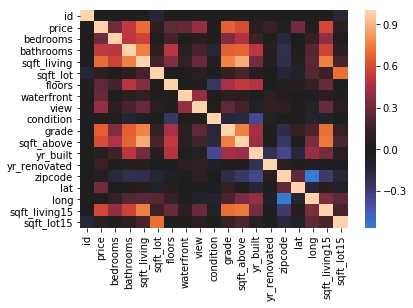

In [16]:
import seaborn as sns
sns.heatmap(data.corr(), center=0);

In [17]:
# Perform log transformation
logbedrooms = np.log(data["bedrooms"])
logliving = np.log(data["sqft_living"])
loglot = np.log(data["sqft_lot"])
loglivingnear = np.log(data["sqft_living15"])
loglotnear = np.log(data["sqft_lot15"])

# Switch the Standardization into the original data
data["bedrooms"] = (logbedrooms-np.mean(logbedrooms))/np.sqrt(np.var(logbedrooms))
data["sqft_living"] = (logliving-np.mean(logliving))/np.sqrt(np.var(logliving))
data["sqft_lot"] = (loglot-np.mean(loglot))/np.sqrt(np.var(loglot))
data["sqft_living15"] = (loglivingnear-np.mean(loglivingnear))/np.sqrt(np.var(loglivingnear))
data["sqft_lot15"] = (loglotnear-np.mean(loglotnear))/np.sqrt(np.var(loglotnear))


# Account for missing data
data.waterfront.fillna(value=data.waterfront.median(), inplace = True)
data.view.fillna(value=data.view.median(), inplace = True)
data.yr_renovated.fillna(value=data.yr_renovated.median(), inplace = True)

In [18]:
# Trying it without grade and sqft above.
X = data.drop(["id","date","sqft_basement", "grade", "sqft_above", "sqft_lot15", "sqft_living15"], axis=1)
y = pd.DataFrame(data, columns = ['price'])

In [19]:
# Perform a train-test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y)
# A brief preview of our train test split
print(len(X_train), len(X_test), len(y_train), len(y_test))

16197 5400 16197 5400


In [20]:
# Apply your model to the train set
from sklearn.linear_model import LinearRegression
linreg = LinearRegression()
linreg.fit(X_train, y_train)
LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [21]:
# Calculate predictions on training and test sets
y_hat_train = linreg.predict(X_train)
y_hat_test = linreg.predict(X_test)

# Calculate training and test residuals
train_residuals = y_hat_train - y_train
test_residuals = y_hat_test - y_test

In [11]:
#Calculate the Mean Squared Error (MSE)
from sklearn.metrics import mean_squared_error

train_mse = mean_squared_error(y_train, y_hat_train)
test_mse = mean_squared_error(y_test, y_hat_test)

print('Train Mean Squarred Error:', train_mse)
print('Test Mean Squarred Error:', test_mse)

Train Mean Squarred Error: 1.4402593252112434e-20
Test Mean Squarred Error: 1.9140513309672663e-20


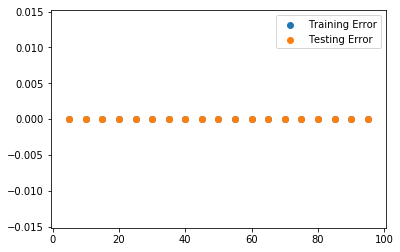

In [12]:
#Evaluate the effect of train-test split 
import random
random.seed(8)
train_err = []
test_err = []
t_sizes = list(range(5,100,5))
for t_size in t_sizes:
    temp_train_err = []
    temp_test_err = []
    for i in range(100):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=t_size/100)
        linreg.fit(X_train, y_train)
        y_hat_train = linreg.predict(X_train)
        y_hat_test = linreg.predict(X_test)
        temp_train_err.append(mean_squared_error(y_train, y_hat_train))
        temp_test_err.append(mean_squared_error(y_test, y_hat_test))
    train_err.append(np.mean(temp_train_err))
    test_err.append(np.mean(temp_test_err))
plt.scatter(t_sizes, train_err, label='Training Error')
plt.scatter(t_sizes, test_err, label='Testing Error')
plt.legend()

In [13]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

cv_5_results  = np.mean(cross_val_score(linreg, X, y, cv=5,  scoring='neg_mean_squared_error'))
cv_5_results

-2.0223207537086747e-19

In [14]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

formula = "price ~ bedrooms+bathrooms+sqft_living+sqft_lot+floors+yr_renovated+view+waterfront+yr_built+zipcode+lat+long"

model = ols(formula= formula, data=data).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.585
Model:                            OLS   Adj. R-squared:                  0.584
Method:                 Least Squares   F-statistic:                     2336.
Date:                Fri, 11 Oct 2019   Prob (F-statistic):               0.00
Time:                        11:11:29   Log-Likelihood:            -2.9791e+05
No. Observations:               21597   AIC:                         5.958e+05
Df Residuals:                   21583   BIC:                         5.960e+05
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept     2.174e+07   3.42e+06      6.367      0.000    1.51e+07    2.84e+07
id           -1.217e-06   5.71e-07     -2.132      0.033   -2.34e-06   -9.81e-08
bedrooms     -4.693e+04   2168.365    -21.644      0.000   -5.12e+04   -4.27e+04
bathrooms     1.108e+05   3724.860     29.738      0.000    1.03e+05    1.18e+05
sqft_living   1.766e+05   3094.653     57.052      0.000     1.7e+05    1.83e+05
sqft_lot      1.052e+04   2100.630      5.010      0.000    6407.515    1.46e+04
floors        4.824e+04   3940.021     12.244      0.000    4.05e+04     5.6e+04
yr_renovated    14.3060      4.620      3.097      0.002       5.251      23.361
view           8.33e+04   2412.711     34.526      0.000    7.86e+04     8.8e+04
waterfront    6.221e+05   2.13e+04     29.152      0.000     5.8e+05    6.64e+05
yr_built     -2387.9285     77.787    -30.698      0.000   -2540.396   -2235.461
zipcode       -792.6238     38.394    -20.644      0.000    -867.879    -717.369
lat           7.187e+05   1.24e+04     57.865      0.000    6.94e+05    7.43e+05
long         -2.187e+05   1.54e+04    -14.177      0.000   -2.49e+05   -1.88e+05
==============================================================================
Omnibus:                    19599.219   Durbin-Watson:                   1.986
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          2235937.986
Skew:                           3.943   Prob(JB):                         0.00
Kurtosis:                      52.219   Cond. No.                     1.15e+13
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.15e+13. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Results

R-squared: 0.585. The more I do the worst it gets!

In [ ]:


encode
plot
